In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random
import progressbar

# Use Louvain method to detect communities
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.centrality import closeness_centrality, group_closeness_centrality

from networkx.algorithms.community import modularity, greedy_modularity_communities

from collections import defaultdict, deque


In [38]:
# Load data
df = pd.read_excel("preferencesRealisticMore.xlsx")
df.set_index(df.columns[0], inplace=True)
names_list = df.index.tolist()

# Create a DataFrame with names as row and column headers, initialize with zeros
df_new = pd.DataFrame(index=names_list, columns=names_list)
df_new.fillna(0, inplace=True)

# Populate the DataFrame with weights
for x in range(len(names_list)):
    for y in range(len(names_list)):
        row = df.iloc[x].tolist()
        name = df_new.index[y]
        if name in row:
            # val = 20 - row.index(name)
            val = row.index(name) + 1
            df_new.iloc[x, y] += val # TODO Check that it is not y, x

# Create a graph from the pandas adjacency matrix
G = nx.from_pandas_adjacency(df_new, create_using=nx.DiGraph)  # Note the use of an undirected graph
G.name = "Graph from pandas adjacency matrix"



In [39]:
# Plotting the graph with communities colored
pos = nx.spring_layout(G)  # Position nodes for better visualization

plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(range(20))  # Generate as many colors as there are communities


# Scale the weights (you may need to adjust the scaling factor)
weights = [G[u][v]['weight'] for u, v in G.edges()]
scaled_weights = [w / max(weights) * 2 for w in weights]  # Adjust scaling factor as needed

# Draw the network edges with arrows and weights influencing thickness
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray', 
                               alpha=0.6, width=scaled_weights)

# nx.draw_networkx_edges(G, pos, alpha=0.5)


In [ ]:
def modularity_change(G, community, u, resolution=1):
    """
    Computes the change in modularity if node u is added to the specified community in a directed graph.

    Parameters:
    ----------
    G : NetworkX DiGraph
        A directed graph from which to detect communities.
    
    community : set
        A set of nodes representing the current community to which we are considering adding node u.
    
    u : node
        The node that is considered to be added to the community.
    
    resolution : float, optional
        The resolution parameter in the modularity definition. Default is 1.
    
    Returns:
    -------
    float
        The change in modularity ΔQ if node u is added to the community.
    """
    
    # Total weight of all edges in the graph
    m = G.size(weight='weight')
    if m == 0:
        return 0
    
    # Node degrees
    in_degree_u = G.in_degree(u, weight='weight')
    out_degree_u = G.out_degree(u, weight='weight')
    
    # Total in-degree and out-degree for nodes in the community
    Stot_in = sum(G.in_degree(v, weight='weight') for v in community)
    Stot_out = sum(G.out_degree(v, weight='weight') for v in community)
    
    # Sum of weights of edges from u to nodes in the community (sum_in)
    sum_in = sum(G[u][v]['weight'] for v in community if G.has_edge(u, v))
    
    # Sum of weights of edges from nodes in the community to u (sum_out)
    sum_out = sum(G[v][u]['weight'] for v in community if G.has_edge(v, u))
    
    # Modularity change
    delta_Q = (sum_in + sum_out) / m
    delta_Q -= resolution * ((Stot_in + in_degree_u) * (Stot_out + out_degree_u)) / (m * m)
    delta_Q += resolution * (Stot_in * Stot_out) / (m * m)
    
    return delta_Q

In [ ]:
array = []

for w in progressbar.progressbar(range(0, 20)): 

    E = G.copy()

    tables = []

    while len(E.nodes) != 0: 

        community = set()
        possiblePartners = set()
        i = 0

        sortedCentralities = list(E.nodes)
            # calculate centrality scores
        random.shuffle(sortedCentralities)


        while len(possiblePartners) == 0 and len(community) < 10: # random.choice(list(set(E.nodes).difference(community)))

            bestCentrality = sortedCentralities[i]
            i += 1

            community.add(bestCentrality)

            for edge in E.in_edges(bestCentrality):
                possiblePartners.add(edge[0])

            for edge in E.out_edges(bestCentrality):
                possiblePartners.add(edge[1])
        
        # repeat 10 timmes

        while len(community) < 10:
            maxModularity = -99999999
            maxModularityPartner = next(iter(possiblePartners))#list(E.nodes)[0] # botch job # better botch

            for possiblePartner in possiblePartners:
                
                modularityFactor = modularity_change(E, community, possiblePartner)

                if modularityFactor > maxModularity: 
                    maxModularity = modularityFactor
                    maxModularityPartner = possiblePartner
                
            # take max node and add it to community
            community.add(maxModularityPartner)
            if maxModularityPartner in possiblePartners: 
                possiblePartners.remove(maxModularityPartner)

            for edge in E.in_edges(maxModularityPartner):
                if edge[0] not in community: 
                    possiblePartners.add(edge[0])

            for edge in E.out_edges(maxModularityPartner):
                if edge[1] not in community: 
                    possiblePartners.add(edge[1])

            while len(possiblePartners) == 0 and len(community) < 10: 
                # get a random node that is not in the community and add it to the community and get its possible partners repeat until there are no more possible partners

                randomNode = random.choice(list(set(E.nodes).difference(community)))

                community.add(randomNode)

                for edge in E.in_edges(randomNode):
                    if edge[0] not in community: 
                        possiblePartners.add(edge[0])

                for edge in E.out_edges(randomNode):
                    if edge[1] not in community: 
                        possiblePartners.add(edge[1])

            # add logic to handel if the number of nodes left is less than 10. 



        # append to table
        tables.append(community)
        # print(tables)
        print(len(tables), end=" ")

        # remove from E
        E.remove_nodes_from(community)

    print(f"\n{w}%", modularity(G, tables))

    array.append((w, modularity(G, tables), tables))



  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


1 2 3 4 5 6 7 8 9 10 11 12 

  5% (1 of 20) |#                        | Elapsed Time: 0:00:04 ETA:   0:01:19


13 14 15 16 17 18 19 20 
0% 0.23420554150387166
1 2 3 4 5 6 7 8 9 10 11 

 10% (2 of 20) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:21


12 13 14 15 16 17 18 19 20 
1% 0.23891698344484247
1 2 3 4 5 6 7 8 9 10 11 12 

 15% (3 of 20) |###                      | Elapsed Time: 0:00:13 ETA:   0:01:13


13 14 15 16 17 18 19 20 
2% 0.24489013534364043
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

 20% (4 of 20) |#####                    | Elapsed Time: 0:00:17 ETA:   0:01:15


15 16 17 18 19 20 
3% 0.2469272992061841
1 2 3 4 5 6 7 8 9 10 11 12 

 25% (5 of 20) |######                   | Elapsed Time: 0:00:22 ETA:   0:01:05


13 14 15 16 17 18 19 20 
4% 0.2385169647699554
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

 30% (6 of 20) |#######                  | Elapsed Time: 0:00:26 ETA:   0:01:02


15 16 17 18 19 20 
5% 0.2404096969639251
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

 35% (7 of 20) |########                 | Elapsed Time: 0:00:31 ETA:   0:01:03


15 16 17 18 19 20 
6% 0.24584511013652233
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

 40% (8 of 20) |##########               | Elapsed Time: 0:00:36 ETA:   0:00:56


19 20 
7% 0.24347421983339834
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

 45% (9 of 20) |###########              | Elapsed Time: 0:00:40 ETA:   0:00:53


16 17 18 19 20 
8% 0.25265035776899375
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

 50% (10 of 20) |############            | Elapsed Time: 0:00:45 ETA:   0:00:44


16 17 18 19 20 
9% 0.25392613641709055
1 2 3 4 5 6 7 8 9 10 11 12 

 55% (11 of 20) |#############           | Elapsed Time: 0:00:49 ETA:   0:00:40


13 14 15 16 17 18 19 20 
10% 0.25143842086841994
1 2 3 4 5 6 7 8 9 10 11 12 

 60% (12 of 20) |##############          | Elapsed Time: 0:00:54 ETA:   0:00:35


13 14 15 16 17 18 19 20 
11% 0.24959253416893154
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 

 65% (13 of 20) |###############         | Elapsed Time: 0:00:59 ETA:   0:00:32


17 18 19 20 
12% 0.2513711845849218
1 2 3 4 5 6 7 8 9 10 11 12 13 

 70% (14 of 20) |################        | Elapsed Time: 0:01:03 ETA:   0:00:27


14 15 16 17 18 19 20 
13% 0.24607070084973823
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

 75% (15 of 20) |##################      | Elapsed Time: 0:01:08 ETA:   0:00:22


18 19 20 
14% 0.24597807738845825
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

 80% (16 of 20) |###################     | Elapsed Time: 0:01:12 ETA:   0:00:18


15 16 17 18 19 20 
15% 0.23955138225645223
1 2 3 4 5 6 7 8 9 10 11 

 85% (17 of 20) |####################    | Elapsed Time: 0:01:17 ETA:   0:00:13


12 13 14 15 16 17 18 19 20 
16% 0.23007432499284508
1 2 3 4 5 6 7 8 9 10 11 12 13 

 90% (18 of 20) |#####################   | Elapsed Time: 0:01:21 ETA:   0:00:08


14 15 16 17 18 19 20 
17% 0.2377528607836397
1 2 3 4 5 6 7 8 9 10 11 12 13 

 95% (19 of 20) |######################  | Elapsed Time: 0:01:25 ETA:   0:00:04


14 15 16 17 18 19 20 
18% 0.2360691406316506
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

100% (20 of 20) |########################| Elapsed Time: 0:01:29 Time:  0:01:29


15 16 17 18 19 20 
19% 0.2420987884302796


In [ ]:
for w, modularity, tables in array: 
    print(f"{w}\t{modularity}")

0	0.23420554150387166
1	0.23891698344484247
2	0.24489013534364043
3	0.2469272992061841
4	0.2385169647699554
5	0.2404096969639251
6	0.24584511013652233
7	0.24347421983339834
8	0.25265035776899375
9	0.25392613641709055
10	0.25143842086841994
11	0.24959253416893154
12	0.2513711845849218
13	0.24607070084973823
14	0.24597807738845825
15	0.23955138225645223
16	0.23007432499284508
17	0.2377528607836397
18	0.2360691406316506
19	0.2420987884302796


In [ ]:
maximum = max(array, key = lambda x: x[1])
print(maximum[1])
tables = maximum[2]

0.25392613641709055


In [ ]:
# tables = greedy_modularity_communities(G, weight="weight", cutoff=20, best_n=20)

In [ ]:
pos = nx.spring_layout(G, weight="weight", iterations=100)

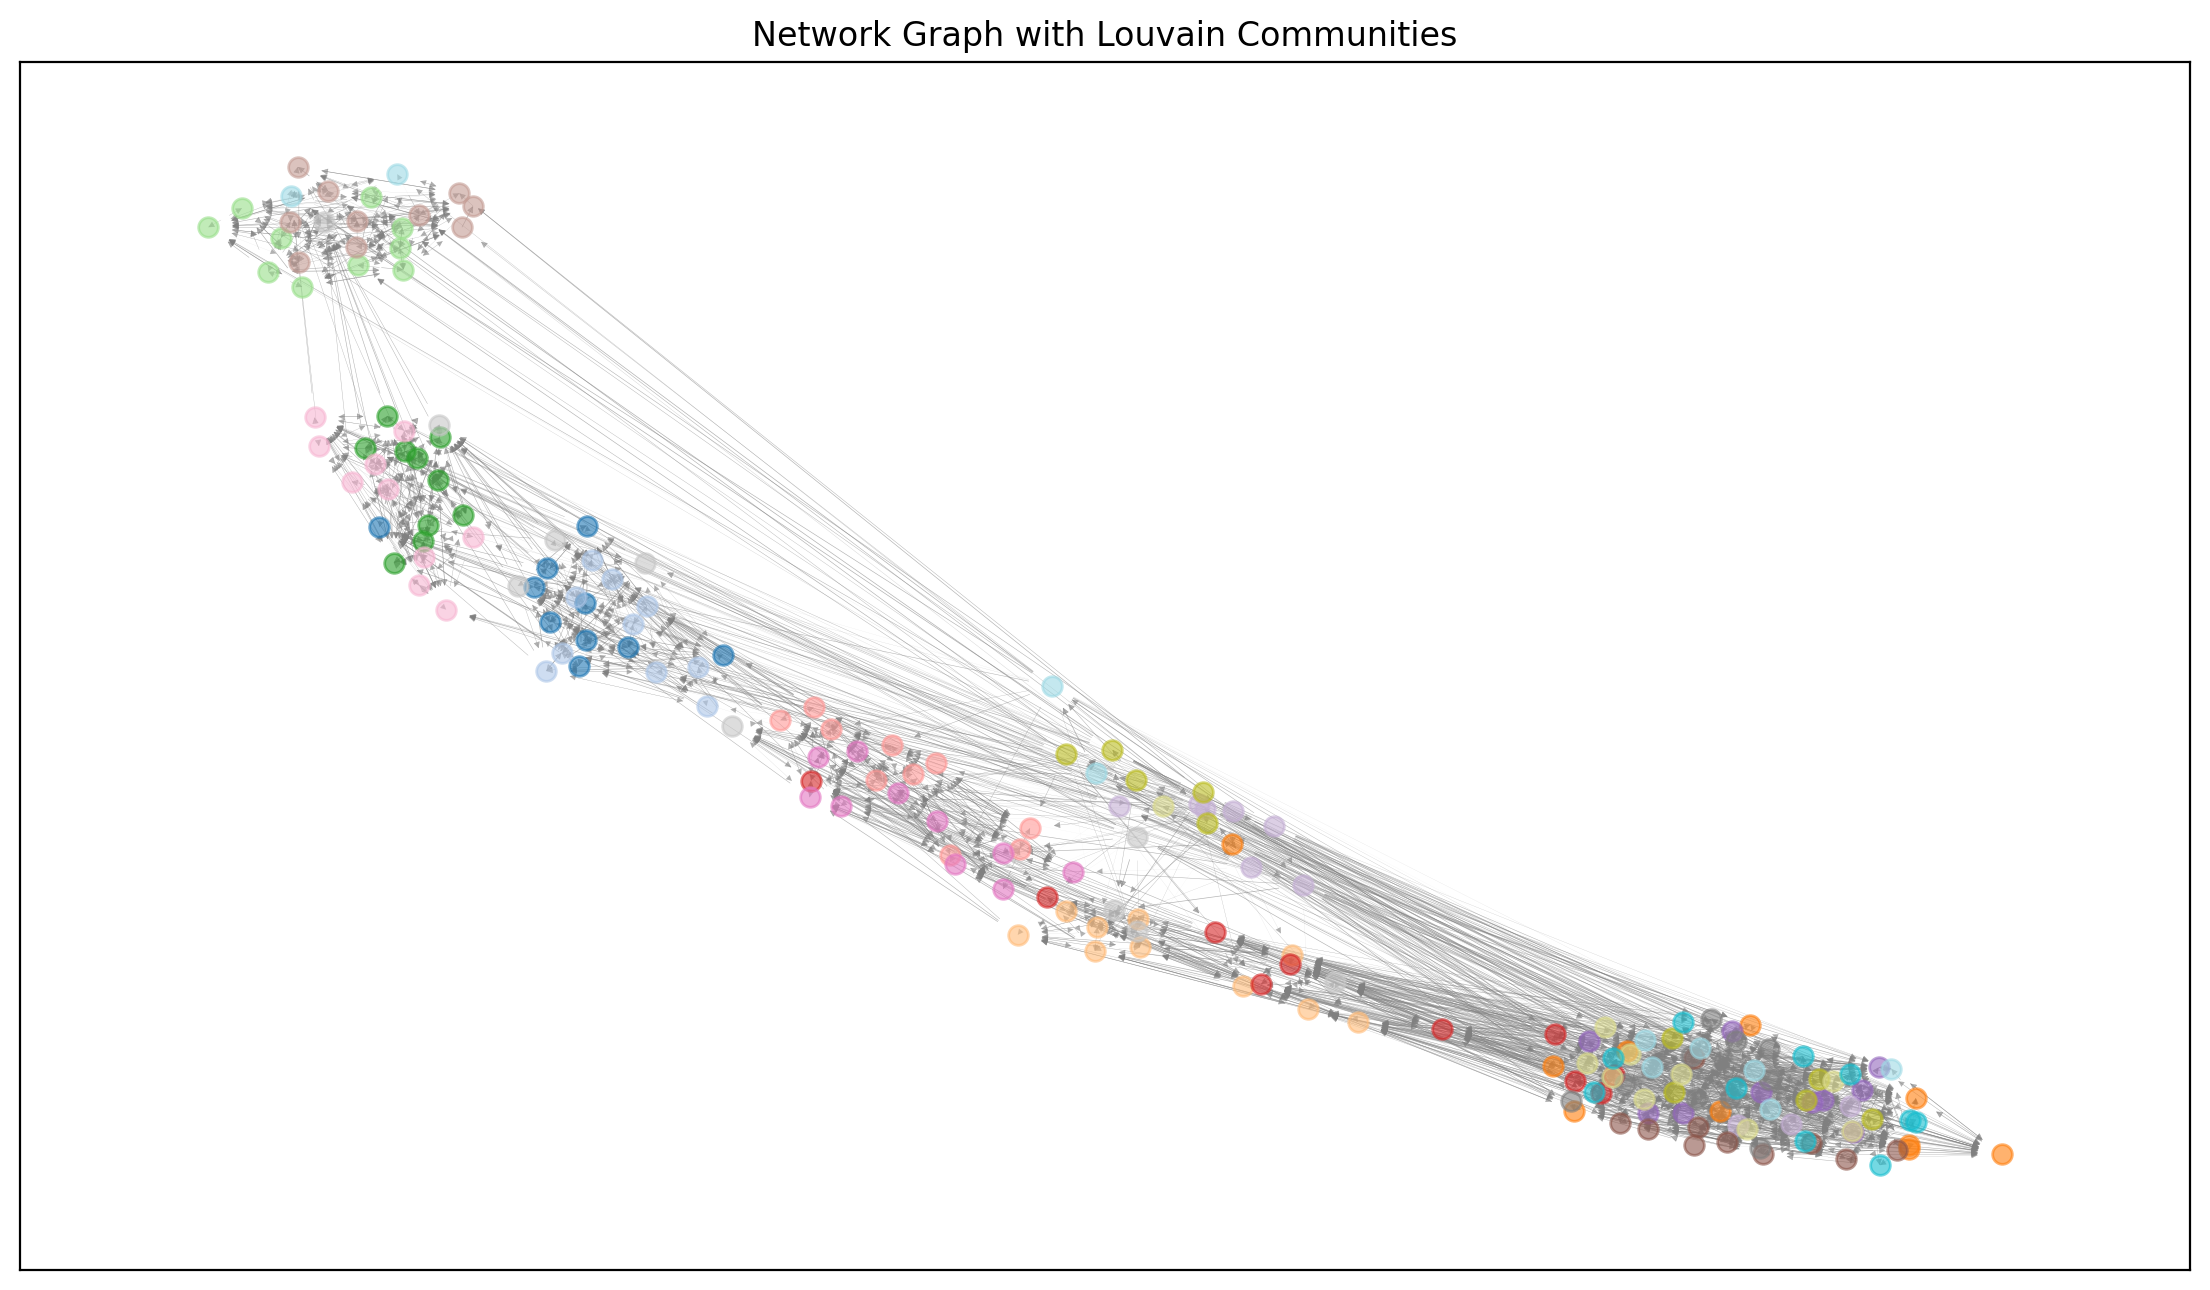

In [ ]:
plt.figure(figsize=(14, 8), dpi=200)

scaled_weights = [0.5 * x for x in scaled_weights]


# Draw the network edges with arrows and weights influencing thickness
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=5, edge_color='gray', 
                               alpha=0.6, width=scaled_weights)


# for table, color in zip(tables, colors) : 
#     nx.draw_networkx_nodes(G, pos, nodelist=table, node_color=[color], node_size=100, alpha=0.6)


# plt.title('Network Graph with Louvain Communities')
# plt.show()

for table, color in zip(tables, colors) : 
    nx.draw_networkx_nodes(G, pos, nodelist=table, node_color=[color], node_size=50, alpha=0.6)


plt.title('Network Graph with Louvain Communities')
plt.show()

In [ ]:
from networkx.algorithms.community import modularity

print(modularity(G, tables))


0.25392613641709055


In [ ]:
print(len(tables))
print(len(G.nodes))

for table in tables:
    print(len(table))

20
200
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [ ]:
for node in G.nodes:
    for num, table in enumerate(tables): 
        if node in table:
            break
    G.nodes[node]["table"] = num
    print(G.nodes[node]["table"])

5
5
5
5
11
11
11
5
5
11
11
5
11
11
5
5
11
19
11
11
5
19
15
4
13
13
13
4
13
13
4
13
4
13
13
13
4
4
4
13
4
4
0
15
4
0
1
1
0
1
1
1
1
0
15
0
0
0
0
0
0
1
1
1
15
1
15
7
12
7
12
7
7
7
12
7
12
12
7
7
7
7
12
12
12
15
12
6
12
3
3
3
3
15
15
3
3
6
3
3
3
6
3
6
15
6
6
14
8
6
19
2
2
2
14
14
10
8
8
10
17
14
17
10
18
17
19
8
14
2
17
6
10
18
10
8
8
8
10
17
10
19
2
14
10
8
2
8
14
18
18
16
18
18
16
18
2
16
17
16
18
18
10
14
14
2
19
18
2
17
10
14
9
6
17
8
17
9
19
16
6
9
19
19
9
16
15
17
9
19
9
2
16
16
9
9
16
9
9
16


In [ ]:
nx.write_gexf(G, "BEST2.gexf")